In [5]:
## Learning while working LSTM models

# Cross Entropy Loss function works well with Label Encoder whereaas Binary Cross Entorpy is used for multi class classification.


# Mutli Task Classification

In [20]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split , RandomizedSearchCV


from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler


from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import optuna

import time

# PyTorch Import

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")


print("Loaded All Libraries.")


Loaded All Libraries.


In [7]:
# Record Constants
INPUT_TRAIN_IN = "../../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../../data/train_out.csv"  
INPUT_TEST_IN = "../../../data/test_in.csv"
INPUT_TEST_OUT = "../../../data/test_out.csv"
INPUT_VALIDATION_IN = "../../../data/valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "../../../data/valid_out.csv"

TARGET_MODEL_PATH = '../../webapp/model_files'


WINDOW_SIZE =  50 # Final RNA Sequence will be 101 Length 
MAX_LENGTH = (WINDOW_SIZE*2) +1

# 1 - One Hot Encoding with Pytorch in build Emnedding 
# 2 - K-mers with Word2Vec
ENCODING_METHOD = 1
FRAMEWORK = "PYTORCH"
PERFORM_DATA_BALANCING = True
K_MERS_SIZE = 3


# Startegy to Crop Sequene
# MID - Modification is present at Mid of cropped Sequence 
# END - Modification is present at End of cropepd Sequence 
CROP_STRATEGY = 'END'

# Y Category Encoding Method
# LABEL or ONE_HOT 
TARGET_ENCODING = 'ONE_HOT'


In [ ]:
hyperparameter = {}
EMBEDDING_DIMENSION = 100
if ENCODING_METHOD == 1:
    hyperparameter['INPUT_DIMENSION'] = 4 # For One Hot Encoding Input Dimension would be 4 as there only 4 unique nucleocide 
if ENCODING_METHOD ==2 :
     hyperparameter['INPUT_DIMENSION'] = EMBEDDING_DIMENSION # Dimension of Word2Vec Model

hyperparameter['HIDDEN_DIMENSION'] = 3
hyperparameter['NO_OF_LAYERS'] = 3
hyperparameter['BATCH_SIZE'] = 32
hyperparameter['OUTPUT_DIMENSION'] =1
hyperparameter['EMBEDDING_DIMENSION'] = EMBEDDING_DIMENSION # if you are using Word2Vec Encoding then this should be same as Word2Vec Embedding Dim 
hyperparameter['DROP_OUT'] = 0.5
NUM_OF_TASK = 13

In [8]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1)

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1 )
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1 )
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1 )


middle_index = (x_train_raw.shape[1] // 2) + 1

if CROP_STRATEGY == 'MID':
    STRAT_INEDX =middle_index - WINDOW_SIZE -1 
    END_INDEX =middle_index + WINDOW_SIZE 

if CROP_STRATEGY == 'END':
    STRAT_INEDX =middle_index - (WINDOW_SIZE*2) -1 
    END_INDEX =middle_index


In [9]:
print(f"Train Shape of X : {x_train_raw.shape} and Tranin Shape of Y : {x_train_raw.shape}")
print(f"Test Shape of X : {x_test_raw.shape} and Test Shape of Y : {y_test_raw.shape}")
print(f"Validation Shape of X : {x_valid_raw.shape} and Validation Shape of Y : {y_valid_raw.shape}")

Train Shape of X : (304661, 1001) and Tranin Shape of Y : (304661, 1001)
Test Shape of X : (1200, 1001) and Test Shape of Y : (1200, 12)
Validation Shape of X : (3599, 1001) and Validation Shape of Y : (3599, 12)


# Encode Y Category

In [10]:
## Filter Dataset to Keep only Target Binary Class 

RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]

def convert_y_to_original_labels(row):
    label = ""
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            label = RMs[index]
    if label == '':
        return 'NonMoD'
    return label

def get_original_y_lables( y_data ):
    # Convert One Hot Encoded Y to to Original Labels 
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    return y_original_labels  



### Encode X  - Vanilla One Hot Encoding

In [11]:
number_of_unique_kmers = set()
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    number_of_unique_kmers.add(kmer_token)
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

def applyOneHotEncoding(tokenized_sequences):
    encoded_sequences = []
    for seq in tokenized_sequences:
        encoded_sequences.append(encode_seq(seq)) 
 
    return np.array(encoded_sequences).flatten()


def encode_with_one_hot_encoding(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    concatenated_column= truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    df_result = truncated_df.assign(Sequence=concatenated_column)
    tokenized_sequences =  df_result['Sequence'].apply(applyOneHotEncoding).tolist()
    return tokenized_sequences


### K-mers with Word2Vec

In [12]:
# Model Documentation - 
# Encode RNA sequences using Word2Vec embeddings
import gensim

all_unique_k_mers = set()

def encode_sequence(sequence, word2vec_model):
    embeddings = []
    for kmer in sequence:
        embeddings.append(word2vec_model.wv[kmer])
    return np.array(embeddings)

def applyKmersAndEncoding(seq):
    k = 3
    tokenized_sequences = [''.join(seq[i:i+k]) for i in range(0, len(seq)-k+1)]
    return tokenized_sequences

def encode_x_with_word2Vec(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    tokenized_sequences =  truncated_df['Sequence'].apply(applyKmersAndEncoding).tolist()

    flat_list = [item for sublist in tokenized_sequences for item in sublist]
    all_unique_k_mers.update(flat_list)

    # The result, tokenized_sequences, is a list of lists, where each inner list
    #  contains the k-mers of the corresponding RNA sequence from the truncated_df list. 

    # Train Word2Vec model on tokenized_sequences (list of lists) instead of unique k-mers
    word2vec_model = gensim.models.Word2Vec(tokenized_sequences, vector_size=EMBEDDING_DIMENSION, window=5, min_count=1, workers=4)
    
    result = []
    for seq in tokenized_sequences:
        embedding = encode_sequence(seq, word2vec_model)
        result.append(embedding)
    return np.array(result)


### Encode Y

In [13]:
ohe = OneHotEncoder(sparse=False)

def encode_target(y_data):
    if TARGET_ENCODING  == 'LABEL':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_data)

    if TARGET_ENCODING == 'ONE_HOT':

        y_encoded = ohe.fit_transform(y_data.values.reshape(-1, 1)) # adding reshape here
      
    return y_encoded

## Prepare Data 

In [14]:
y_train_original =  get_original_y_lables(y_train_raw)
y_test_original =  get_original_y_lables(y_test_raw )
y_valid_original =  get_original_y_lables(y_valid_raw)


sm = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sm.fit_resample(x_train_raw, y_train_original)


print(y_resampled.value_counts())

y_train_one_hot = encode_target(y_resampled)
y_test_one_hot = encode_target(y_test_original)
y_valid_one_hot = encode_target(y_valid_original)

print("Completed Target Enconding.")

if ENCODING_METHOD ==1:
     X_train = torch.tensor(encode_with_one_hot_encoding(X_resampled) , dtype=torch.long)
     X_test = torch.tensor(encode_with_one_hot_encoding(x_test_raw) , dtype=torch.long)
     X_valid = torch.tensor(encode_with_one_hot_encoding(x_valid_raw) , dtype=torch.long)

# # if ENCODING_METHOD == 2:
# #     X_train = torch.tensor(encode_x_with_word2Vec(X_resampled) , dtype=torch.float32)
# #     X_test = torch.tensor(encode_x_with_word2Vec(x_test_raw) , dtype=torch.float32)
# #     X_valid = torch.tensor(encode_x_with_word2Vec(x_valid_raw) , dtype=torch.float32)

print("Completed Feature Encoding.")
# # #Caste to Torch Tensor
y_train =torch.tensor(y_train_one_hot , dtype=torch.float) #  torch.tensor(y_resampled, dtype=torch.long)
y_test = torch.tensor(y_test_one_hot, dtype=torch.float)
y_valid = torch.tensor(y_valid_one_hot, dtype=torch.float)


y_train.shape


hAm       152208
NonMoD    152208
hm6Am     152208
hCm       152208
hGm       152208
hTm       152208
hm1A      152208
hm6A      152208
hm5C      152208
hm5U      152208
hm7G      152208
hPsi      152208
Atol      152208
Name: count, dtype: int64


c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_36944\1148330243.py:18: UserWarning: Creating a tensor from

torch.Size([1978704, 13])

### Hyper Parameters

### LSTM Model with Multi Task Binary Classification (Works with Label Encoder)

In [21]:
 
class RNADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


class RNAClassifier(nn.Module):
    def __init__(self, input_dim,embedding_dim, hidden_dim,num_layers, output_dim , dropout=0.5):
        super(RNAClassifier, self).__init__()

        #Pytroch Embedding 
        self.embedding = nn.Embedding(input_dim,embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers, batch_first=True )

        #Fully Connected Layer for Each Task
        self.fc = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(NUM_OF_TASK)])

        # Drop out layer for Overfitting 
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):

        x  = x.long()

        x_embeded =  self.embedding(x)

        lstm_out, (h,c) = self.lstm(x_embeded)

        out = [fc(h[-1]).squeeze(1) for fc in self.fc]
    
        return out 

def validate_model(model, test_dataloader, device, loss_functions):
    model.eval()
    running_loss = 0.0

    original_preds = []
    original_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            loss = 0.0 

            outputs = model(inputs)
            
            for i, (output, loss_func) in enumerate(zip(outputs, loss_functions)):
                loss += loss_func(output, labels[:, i])

            running_loss += loss.item()
            
            # Basically I am doing here is each is output is passed through sigmoid function to it can range between 0 -> 1
            predicted = [torch.sigmoid(output) for output in outputs]
            final_predicted_lables = torch.stack(predicted).T #  .T Transpose is required to match with final target lables.

            # Now once you have array of 13 output , you pick max one as your final predicted result 
            max_indices = torch.argmax(final_predicted_lables, dim=1)

            # Now Conver that max result to 1 and rest should be 0 
            one_hot_tensor = F.one_hot(max_indices, num_classes=final_predicted_lables.shape[1])
            one_hot_tensor = one_hot_tensor.to(torch.float)
            

            # Use ohe now get back original labels
            original_preds.extend(ohe.inverse_transform(one_hot_tensor.cpu().numpy()))  
            original_labels.extend(ohe.inverse_transform(labels.cpu().numpy()))


        # Convert lists to numpy arrays
    original_preds = np.array(original_preds).flatten()
    original_labels = np.array(original_labels).flatten()
    
    validation_loss = running_loss / len(test_dataloader)

    # Below code is just calculated accuracy.
    validation_accuracies = {}

    overall_accuracy = accuracy_score(original_preds , original_labels)

    print("Overall Accuracy : " , overall_accuracy)

    # Calculating Accuracy for each class
    class_accuracies = []
    for i in RMs:
        class_indices = np.where(np.array(original_labels) == i)
        if len(class_indices[0]) > 0:
            acc = (np.array(original_preds)[class_indices] == i).mean()
        else:
            acc = 0.0
        class_accuracies.append(acc)

    for rm, acc in zip(RMs, class_accuracies):
        validation_accuracies[rm] = acc

    return validation_loss, validation_accuracies , original_labels, original_preds , overall_accuracy

import time

def train_model(model, train_dataloader, test_dataloader, device, epochs, optimizer, loss_functions):
    prev_accuracy = 0.0
    stagnant_epochs = 0

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            loss = 0.0 
            
            optimizer.zero_grad()

            outputs = model(inputs)
            for i, (output, loss_func) in enumerate(zip(outputs, loss_functions)):
                loss += loss_func(output, labels[:, i])

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
      
        val_loss, val_acc , original_labels, original_preds  ,overall_accuracy  = validate_model(model, test_dataloader, device, loss_functions)

        # Check if overall accuracy has improved
        if overall_accuracy <= prev_accuracy:
            stagnant_epochs += 1
        else:
            stagnant_epochs = 0

        # If accuracy hasn't improved for 3 epochs, stop training
        if stagnant_epochs >= 3:
            print("Training stopped: Overall accuracy has not increased for last 3 epochs")
            break

        # Update previous accuracy
        prev_accuracy = overall_accuracy

        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc}, Time: {elapsed_time:.2f} seconds")

In [22]:
print("Started Model Training..")
print(hyperparameter)

# Create dataset and dataloader
train_dataset = RNADataset(X_train, y_train)
test_dataset = RNADataset(X_test, y_test)
valid_dataset = RNADataset(X_valid, y_valid)

train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

# Initialize the model, loss function, and optimizer
if ENCODING_METHOD == 1:
    model = RNAClassifier(input_dim=hyperparameter['INPUT_DIMENSION'],
                                embedding_dim=hyperparameter['EMBEDDING_DIMENSION'], 
                                hidden_dim=hyperparameter['HIDDEN_DIMENSION'] , 
                                num_layers = hyperparameter['NO_OF_LAYERS'],
                                output_dim=hyperparameter['OUTPUT_DIMENSION'],
                                dropout=hyperparameter['DROP_OUT'] )


# Loss for 13 binary classification tasks
loss_functions = [nn.BCEWithLogitsLoss() for _ in range(NUM_OF_TASK)] 
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Number of Parameters for Model
total_parameters = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters for Model Training : {total_parameters}")

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train Model with configured Parameter
train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_functions)


Started Model Training..
{'INPUT_DIMENSION': 4, 'HIDDEN_DIMENSION': 3, 'NO_OF_LAYERS': 3, 'BATCH_SIZE': 32, 'OUTPUT_DIMENSION': 1, 'EMBEDDING_DIMENSION': 3, 'DROP_OUT': 0.5}
Total Number of Parameters for Model Training : 352
Overall Accuracy :  0.22166666666666668
Epoch 1, Train Loss: 2.0150, Val Loss: 3.2712, Val Acc: {'hAm': 0.12, 'hCm': 1.0, 'hGm': 0.64, 'hTm': 0.02, 'hm1A': 0.0, 'hm5C': 0.0, 'hm5U': 0.0, 'hm6A': 1.0, 'hm6Am': 1.0, 'hm7G': 0.56, 'hPsi': 0.98, 'Atol': 0.0, 'NonMoD': 0.0}


KeyboardInterrupt: 

### Calculate Confusion Matrix Accuracy by Each Class 

Overall Accuracy :  0.24173381494859683
Accuracy for class hAm: nan
Accuracy for class hCm: 0.25
Accuracy for class hGm: 0.3686274509803922
Accuracy for class hTm: 0.17408906882591094
Accuracy for class hm1A: 0.06666666666666667
Accuracy for class hm5C: nan
Accuracy for class hm5U: 0.17638036809815952
Accuracy for class hm6A: 0.21255349500713266
Accuracy for class hm6Am: 0.3080082135523614
Accuracy for class hm7G: 0.3159420289855073
Accuracy for class hPsi: nan
Accuracy for class Atol: 0.19594594594594594
Accuracy for class NonMoD: 1.0


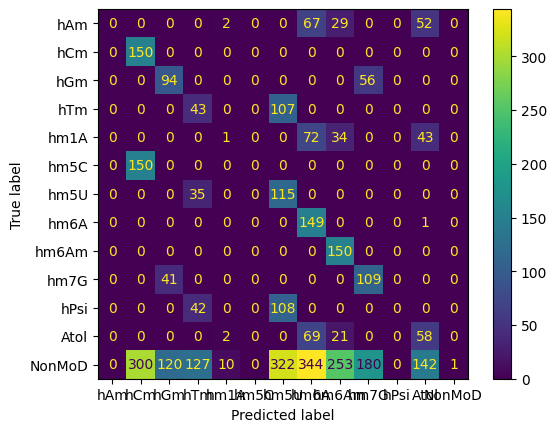

In [23]:
_, validation_accuracies,  original_labels, original_preds , overall_accuracy = validate_model(model, valid_dataloader, device, loss_functions)

cm = confusion_matrix(original_labels, original_preds, labels=RMs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=RMs)
disp.plot()

class_accuracies = [(np.array(original_labels)[np.array(original_preds) == i] == i).mean() for i in RMs]
for rm, acc in zip(RMs, class_accuracies):
    print(f"Accuracy for class {rm}: {acc}")

### RNA Classifier with Word2Vec Model

In [ ]:

# class RNAClassifierWithWord2Vec(nn.Module):
#     def __init__(self, input_dim,embedding_dim, hidden_dim,num_layers, output_dim , dropout=0.5):
#         super(RNAClassifierWithWord2Vec, self).__init__()
        
#         #Bi-Directional LSTM Model
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers, batch_first=True , bidirectional=True)

#         # Attention Layer - 2 * hidden dimension since we are using bi-directional lstm
#         self.attention = BahdanauAttention(2 * hidden_dim)

#         #Fully Connected Layer   
#         self.fc = nn.Linear(2*hidden_dim, output_dim) 

#         # Drop out layer for Overfitting 
#         self.dropout = nn.Dropout(dropout)


#     def forward(self, x):

#         lstm_out, (h,c) = self.lstm(x)

#         # Concatenate the hidden states from both directions
#         h = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)

#         # Calculate Context Vector and Attention Weight
#         context_vector , attention_weights =  self.attention(h , lstm_out)
        
#         # Pass it to drop out layer 
#         context_vector = self.dropout(context_vector)
        
#         # Finally pass it to fully connected layer.
#         out = self.fc(context_vector)
        
#         return out # Sequeez to Single dimension for loss calculation


### Train Model

### Calculate Model Accuracy

### Optuna Hyperparameter Training

In [18]:
import optuna

def objective(trial):
    # Define hyperparameters with Optuna
    hyperparameter = {
        'INPUT_DIMENSION': 4 ,
        'HIDDEN_DIMENSION': trial.suggest_int('HIDDEN_DIMENSION', 32, 512),
        'NO_OF_LAYERS': trial.suggest_int('NO_OF_LAYERS', 1, 5),
        'BATCH_SIZE': trial.suggest_categorical('BATCH_SIZE', [32, 64, 128]),
        'OUTPUT_DIMENSION': 1,
        'EMBEDDING_DIMENSION': trial.suggest_categorical('EMBEDDING_DIMENSION', [32, 64, 128 , 256 , 512]),
        'DROP_OUT': trial.suggest_uniform('DROP_OUT', 0.1, 0.5),
        'LEARNING_RATE': trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-1)
    }

    # Initialize the model
    model = RNAClassifier(input_dim=hyperparameter['INPUT_DIMENSION'],
                        embedding_dim=hyperparameter['EMBEDDING_DIMENSION'], 
                        hidden_dim=hyperparameter['HIDDEN_DIMENSION'] , 
                        num_layers = hyperparameter['NO_OF_LAYERS'],
                        output_dim=hyperparameter['OUTPUT_DIMENSION'],
                        dropout=hyperparameter['DROP_OUT'] )
    
    model = model.to(device)

    # Create dataset and dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

    # Loss for 13 binary classification tasks
    loss_functions = [nn.BCEWithLogitsLoss() for _ in range(NUM_OF_TASK)] 
    
    # Optimizer with learning rate from hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=hyperparameter['LEARNING_RATE'])

    # Train Model with configured Parameter
    train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_functions)

    # Run validation and get overall accuracy
    _, _, _, _, overall_accuracy = validate_model(model, valid_dataloader, device, loss_functions)

    return overall_accuracy

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the result
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))


[I 2023-05-21 21:42:23,170] A new study created in memory with name: no-name-782a4b1e-0999-4fba-aa41-98038fe44106
C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_36944\3932780915.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'DROP_OUT': trial.suggest_uniform('DROP_OUT', 0.1, 0.5),
C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_36944\3932780915.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'LEARNING_RATE': trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-1)
[W 2023-05-21 21:46:16,563] Trial 0 failed with parameters: {'HIDDEN_DIMENSION': 9, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 64, 'EMBEDDING_DIMENSION': 32, 'DROP_OUT': 0.41062853138

KeyboardInterrupt: 

### LSTM Model with Binary Cross Entropy Loss (Works with One Hot Encoder)

In [ ]:
# ## Define LSTM and Train

# class RNADataset(Dataset):
#     def __init__(self, X, y):
#         self.X = X
#         self.y = y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, index):
#         return self.X[index], self.y[index]

# class RNAClassifier_BCE(nn.Module):
#     def __init__(self, unqique_k_mer_size, embedding_dim,hidden_dim,num_layers, output_dim):
#         super(RNAClassifier_BCE, self).__init__()
#         self.embedding  = nn.Embedding(unqique_k_mer_size,embedding_dim)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):

#         x_embeded = self.embedding(x)
#         _, (hidden, _) = self.lstm(x_embeded)

#        # print("Hidden Dimansion : " , hidden.shape)
#         x = self.fc(hidden[-1]) # Squeeze does not make any differecent in Tensor , basically removing 0 demsion from tensor 

#         # When we squeeze a tensor, the dimensions of size 1 are removed. 
#         # The elements of the original tensor are arranged with the remaining dimensions. For example, 
#         # if the input tensor is of shape: (m×1×n×1) then the output tensor after squeeze will be of shape: (m×n). 

#         # print("Ouput  Dimansion : " ,x.shape)      

#         # print("Result After Applygin Softmax : " , torch.softmax(x, dim=-1) )                                      
#         return x



# if MODEL==1 :
#     print("Excuting LSTM Model")

#     # Create dataset and dataloader
#     print("X Shape of Tensor : " , X_train.shape , " Y Tensor Shape : " , y_train.shape)
#     print("HyperParameter for Training : ", hyperparameter)
#     train_dataset = RNADataset(X_train, y_train)
#     test_dataset = RNADataset(X_test, y_test)

#     train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

#     # Calculating INPUT_DIMENSION for LSTM Mode 
#     # If you are just using One Hot then INPUT_DIMENSION would be 4 because there are 4 possible unique nucleosides
#     # But if you are using K mers then INPUT_DIMENSION would be number of unique k-mers on all dataset

#     # LSTM model Format - (batch_size, sequence_length, input_size)  
#     # batch_size comes from DataLoaded , you can tune it.
#     # Sequence Length - Lenth of X[0] shape (32, 19, 12)  Here 19 is sequence length , 
#     # Input Size = 12 length of X[0][0] - Basically all unique nucleoside or k-mers

#     # Initialize the model, loss function, and optimizer
#     # model = RNAClassifier_BCE(input_size=4788, 
#     #                           hidden_size=hyperparameter['HIDDEN_DIMENSION'] , 
#     #                           num_layers = hyperparameter['NO_OF_LAYERS'],
#     #                           output_size=hyperparameter['OUTPUT_DIMENSION'] )
#     model = RNAClassifier_BCE(unqique_k_mer_size=hyperparameter['INPUT_DIMENSION'],
#                               embedding_dim=hyperparameter['EMBEDDING_DIMENSION'] 
#                               hidden_dim=hyperparameter['HIDDEN_DIMENSION'] , 
#                               num_layers = hyperparameter['NO_OF_LAYERS'],
#                               output_dim=hyperparameter['OUTPUT_DIMENSION'] )
    
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters())

#     # Number of Parameters for Model
#     total_parameters = []
#     for p in model.parameters():
#         total_parameters.append(p.numel())
    
#     print(f"Total Number of Parameters for Model Training : { sum(total_parameters)} " )

#     # Train the model
#     num_epochs = 10
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for i, (inputs, labels) in enumerate(train_dataloader):
#             inputs, labels = inputs.to(device), labels.to(device)

#             print("Target Labesl : " , labels.shape)
#             print("Ouput Labesl : " , outputs.shape)

#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
            
#         epoch_loss = running_loss / len(train_dataloader)
#         print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")




In [ ]:
model.eval()
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        outputs = model(x_batch)
        
        # Basically models predict probability for each class and then finally we pick up with hightest probabiliyt class 
        # and then compare with actual class to calculate accuracy. 
        
        ## Predicted torch.max(outputs, 1) 
#         values=tensor([0.7304, 0.4554, 0.3984, 0.4091, 0.9271, 0.4370, 0.3837, 0.4395, 0.4005,
#         0.5451, 0.5642, 0.6866, 0.5768, 0.5160, 0.5093, 0.4947, 0.6823, 0.4612,
#         0.4073, 0.5041, 0.6982, 0.4116, 0.4092, 0.5589, 0.6010, 0.4693, 0.6324,
#         0.5524, 0.4339, 0.7889, 0.5216, 0.6588]),
#         indices=tensor([ 1, 10, 10, 10,  1, 10, 10, 10,  1, 10,  1,  1,  0,  1,  1, 10,  1, 10,
#         10, 10, 10,  1, 10,  0, 10,  1,  1,  0, 10,  1,  1,  0]))

        _, predicted = torch.max(outputs, 1)  # Get the class index with the highest probability
        #print(torch.max(outputs, 1))
        true_labels = torch.max(y_batch, 1).indices  # Get the true class indices from the one-hot encoded labels [0,1,0,0,,,... ] Get index of 1
        correct_predictions += (predicted == true_labels).sum().item()
        total_predictions += y_batch.size(0)

accuracy = correct_predictions / total_predictions


print(f"Validation Accuracy: {accuracy:.4f}")
